In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize
from sklearn.preprocessing import StandardScaler
import string
from Bio import Cluster
from scipy.interpolate import interp1d

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', -1)

# Import file

In [2]:
df = pd.read_csv(r"C:\\Users\\bnguitto\\Desktop\\ECU\\ECU10HZ\\csvCycle0\\05_drivingCycle00.dat.csv",index_col=[0])
df = df.fillna(method='ffill')

Delete correlations

In [3]:
# delete remaining correlations
def deleteCorrelations(df, threshold):
    corr = df.corr()
    pairs = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
    pairs = pairs.where(pairs>threshold).dropna()
    columnsToKeep = []
    columnsToDelete = []
    listP = []
    for key in pairs.keys() :
        if key[0] != key[1] :
            listP.append([key[0],key[1]])
    if listP == []:
        return df
    else:
        for pair1 in listP:
            if (pair1[0] not in columnsToDelete) and (pair1[0] not in columnsToKeep):
                columnsToKeep.append(pair1[0])
            if (pair1[1] not in columnsToDelete) and (pair1[1] not in columnsToKeep):
                columnsToDelete.append(pair1[1])
        return deleteCorrelations(df.drop(columns = columnsToDelete),threshold)
    
newDf = deleteCorrelations(df,0.95)

# Data scaling

In [80]:
# Min max scaling
def MinMaxScaler(df,columns):
    newDf = df.copy()
    for column in columns:
        newDf[column] -= newDf[column].min()
        newDf[column] /= newDf[column].max()
    return newDf
        
def MinMaxScaler(df):
    newDf = df.copy()
    newDf -= newDf.min()
    newDf /= newDf.max()
    return newDf
    
# Standard Scaling
def StandardScaler(df,columns):
    newDf = df.copy()
    for column in columns:
        newDf[column] = (newDf[column]-newDf[column].mean())/newDf[column].std()
    return newDf
        
def MyStandardScaler(df):
    newDf = df.copy()
    newDf = (newDf-newDf.mean())/newDf.std()
    return newDf

Discretisation and segmentation

In [25]:
# mean based discretisation
def AvgDiscretisation(df,segmentSize):
    newDf = pd.DataFrame(columns=df.columns)
    nbSegments = math.ceil(len(df)/segmentSize)
    segments = np.array_split(df,nbSegments)
    for i in range(len(segments)):
        newDf.loc[i] = segments[i].mean().values
    return newDf

# linear regression based discretisation
def RegDiscretisation(df,segmentSize):
    newDf = pd.DataFrame(columns=df.columns)
    nbSegments = math.ceil(len(df)/segmentSize)
    segments = np.array_split(df,nbSegments)
    for i in range(len(segments)):
        regression_model = LinearRegression()
        for c in segments[i].columns :
            regression_model.fit(segments[i]['time'].values.reshape(-1,1),segments[i][c].values)
            newDf.loc[i,c] = float(regression_model.coef_)
    return newDf

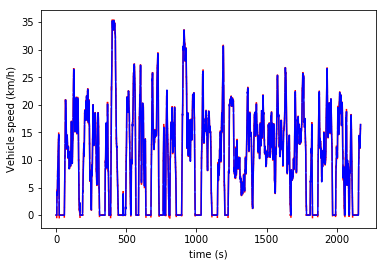

In [24]:
def plotLR(df,column,segmentSize):
    newDf = pd.DataFrame(columns = ['time',column])
    nbSegments = math.ceil(len(df)/segmentSize)
    segments = np.array_split(df,nbSegments)
    for i in range(len(segments)):
        regression_model = LinearRegression()
        regression_model.fit(segments[i]['time'].values.reshape(-1,1),segments[i][column].values)
        plt.plot(segments[i]['time'],regression_model.predict(segments[i]['time'].values.reshape(-1,1)),color='r')
    plt.plot(df['time'],df[column],color='b')
    plt.xlabel('time (s)')
    plt.ylabel('Vehicle speed (km/h)')   

def plotAvg(df,column,segmentSize):
    newDf = AvgDiscretisation(df[['time',column]],segmentSize)
    plt.plot(newDf['time'],newDf[column],color='r')
    plt.plot(df['time'],df[column],color='b')
    plt.xlabel('time (s)')
    plt.ylabel('Vehicle speed (km/h)')
    
plotLR(df,'VehV_v',10)

In [8]:
def SAXtransform(df,nbCuts):
    ndf = pd.DataFrame()
    cuts = cuts_for_asize(nbCuts)
    for c in df.columns:
        ndf[c] = list(ts_to_string(df[c].values, cuts))      
    return ndf

def convertLR1(x,thresh):
    if x<-thresh:
        return 'C'
    elif x>thresh:
        return 'A'
    else:
        return 'B'
    
def convertLR2(x,thresholdList):
    letters =[i for i in string.ascii_uppercase]
    n = len(thresholdList) - 1
    letters = letters[0:n]
    for i in range(n):
        if x>thresholdList[i] and x<thresholdList[i+1]:
            return letters[n-i-1]
    
def LRtransform1(df,thresh):
    return df.applymap(lambda x : convertLR1(x,thresh))

def LRtransform2(df,thresholdList):
    return df.applymap(lambda x : convertLR2(x,thresholdList))

Scale and segment

In [ ]:
dfNormal = StandardScaler(df)
dfMinMax = MinMaxScaler(df)

dfNormalAvg = AvgDiscretisation(dfNormal,10)
dfNormalReg = RegDiscretisation(dfNormal,10)
dfMinMaxReg = RegDiscretisation(dfMinMax,10)

Symbolic representation

In [383]:
# Get normal representation for hoops identification
thresholds = [-np.inf,-250,-40,40,250,np.inf]
dfNormalLR = LRtransform2(RegDiscretisation(MyStandardScaler(df[['time','Epm_nEng','APP_r','ActMod_trqClth']]),10),thresholds)

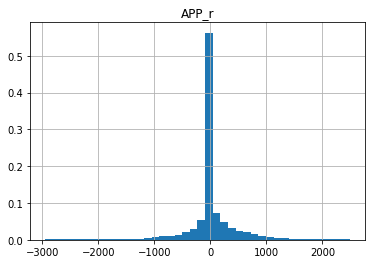

In [377]:
test = RegDiscretisation(MyStandardScaler(df[['time','APP_r']]),10)
test.apply(pd.to_numeric).hist('APP_r',bins=40, weights=np.ones(len(test)) / len(test))

# find the 0 centered window that contains a certain percentage of the values (data must me normally scaled)
def findOptimum(torque,eps,percentage,column,value=None,maxValue=None):
    maxValue = maxValue or torque[column].max()
    value = value or torque[column].max()/2
    proportion = len(torque.loc[(torque[column]<value) & (torque[column]>-value)]) / len(torque)
    if abs(proportion-percentage)<eps:
        return value
    else:
        if proportion>percentage:
            return findOptimum(torque,eps,percentage,column,value/2,value)
        else:
            return findOptimum(torque,eps,percentage,column,value,(value+maxValue)/2)

# Hoops identification

In [45]:
def splitSAX(chaine):
    if ('c' in chaine) and 'a' == chaine[-1]:
        return True
    else:
        return False 

def splitEngineTorqueIncrease1(chaine) :
    if ('C' in chaine) or ('B' in chaine) :
        if 'A' == chaine[-1] :
            return True
        else :
            return False
    else :
        return False
    
def splitEngineTorqueIncrease2(chaine) :
    if ('C' in chaine) or ('D' in chaine) or ('E' in chaine) :
        if 'A' == chaine[-1] or 'B' == chaine[-1]:
            return True
        else :
            return False
    else :
        return False

def splitHoops(df,referenceKey,splitFunction):
    listdf = []
    curseur = 0
    listValeurAct = []
    for value in df[referenceKey]:
        listValeurAct.append(value)
        if splitFunction(listValeurAct):
            # split
            listdf.append(df[curseur:curseur + len(listValeurAct) - 1])
            curseur = curseur + len(listValeurAct) - 1
            listValeurAct = [value]
    listdf.append(df[curseur:df.shape[0]])
    return listdf

def getValuesHoops(listHoops,df,segmentSize):
    hoopsValues = []
    for hoop in listHoops:
        index = [i for i in hoop.index]
        start = index[0]*segmentSize
        end = index[-1]*segmentSize
        hoopsValues.append(df.loc[start:end])
    return hoopsValues

349

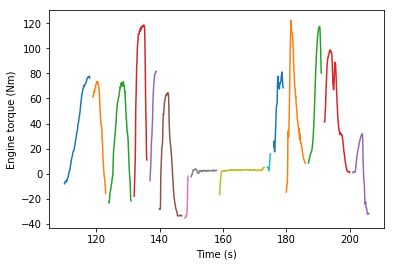

In [386]:
# Visualize identification (based on engine torque)
listHoops = splitHoops(dfNormalLR,'ActMod_trqClth',splitEngineTorqueIncrease2)
listValuesHoops = getValuesHoops(listHoops,df,10)
for hoop in listValuesHoops[15:30]:
    plt.plot(hoop['time'],hoop['ActMod_trqClth'])
plt.xlabel('Time (s)')
plt.ylabel('Engine torque (Nm)')

305

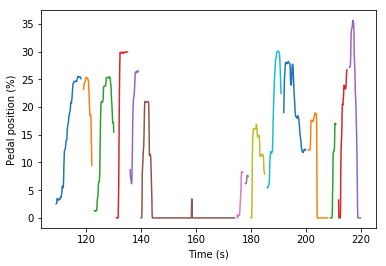

In [385]:
# Visualize identification (based on pedal acceleration)
listHoops = splitHoops(dfNormalLR,'APP_r',splitEngineTorqueIncrease2)
listValuesHoops = getValuesHoops(listHoops,df,10)
for hoop in listValuesHoops[15:30]:
    plt.plot(hoop['time'],hoop['APP_r'])
plt.xlabel('Time (s)')
plt.ylabel('Pedal position (%)')

Text(0, 0.5, 'Torque (Nm)')

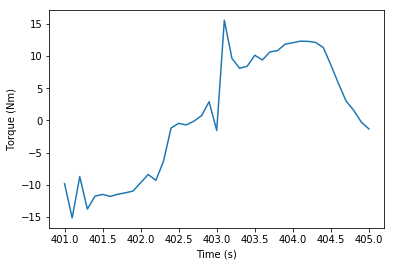

In [268]:
# Visualize engine torque hoop
hoop = listValuesHoops[53]
plt.plot(hoop['time'],hoop['ActMod_trqClth'])
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")

Text(0, 0.5, 'Torque (Nm)')

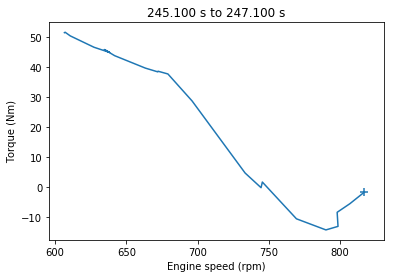

In [87]:
# Visualize engine torque VS engine speed hoop
hoop = listValuesHoops[53]
plt.plot(hoop['Epm_nEng'],hoop['ActMod_trqClth'])
time = hoop['time'].values
plt.title('%.3f s to %.3f s' % (time[0],time[-1]))
plt.scatter(hoop['Epm_nEng'].values[0],hoop['ActMod_trqClth'].values[0],marker="+",s=80)
plt.xlabel("Engine speed (rpm)")
plt.ylabel("Torque (Nm)")

# Clustering of hoops

Distance functions to get the pairwise distance matrix

In [403]:
# Distance matrix between hoops using pairwise sequence alignement
def distanceMatrix1(listHoops,column):
    n = len(listHoops)
    matrix = pd.DataFrame(0.0, index=np.arange(n), columns=np.arange(n))
    for i in range(n):
        matrix.iloc[i][i] = 1
        hoop1 = ''.join(listHoops[i][[column]].values.flatten().tolist())
        n1 = len(hoop1)
        for j in range(i+1,n):
            hoop2 = ''.join(listHoops[j][[column]].values.flatten().tolist())
            n2 = len(hoop2)
            distance = pairwise2.align.globalxx(hoop1, hoop2, score_only=True) / (max(n1,n2))
            matrix.iloc[i][j] = distance
            matrix.iloc[j][i] = distance
    return 1.0-matrix   

# Distance matrix between hoops using DTW algorithm
def distanceMatrix2(listHoopsValues,column1,column2):
    n = len(listHoopsValues)
    matrix = pd.DataFrame(0.0, index=np.arange(n), columns=np.arange(n))
    for i in range(n):
        matrix.iloc[i][i] = 0
        hoop1 = listHoopsValues[i][[column1,column2]].values
        for j in range(i+1,n):
            hoop2 = listHoopsValues[j][[column1,column2]].values
            distance, path = fastdtw(hoop1, hoop2, dist=euclidean)
            matrix.iloc[i][j] = distance
            matrix.iloc[j][i] = distance
    return matrix

def kmeansDist(distanceMatrix,k,nits):
    n = len(distanceMatrix)
    energy = np.inf
    centers = []
    labels = []
    for its in range(nits):
        newCenters = random.randint(0,n,k)
        newLabels = [None] * n 
        newEnergy = 0
        for h in range(n):
            distances = [distanceMatrix.iloc[h][c] for c in newCenters]
            newLabels[h] = distances.index(min(distances))
            newEnergy += distanceMatrix.iloc[h][newLabels[h]]
        if newEnergy < energy:
            energy = newEnergy
            centers = newCenters
            labels = newLabels
            print(energy)
        print(its)
    return labels, centers

def kmeans2(distanceMatrix,k):
    n = len(distanceMatrix)
    mins = np.argsort(distanceMatrix.sum().values)[0:k]
    labels = [None] * n 
    energy = 0
    for h in range(n):
        distances = [distanceMatrix.iloc[h][c] for c in mins]
        labels[h] = distances.index(min(distances))
        energy += distanceMatrix.iloc[h][labels[h]]
    return labels, energy

In [358]:
# First approach, doesn't work well
label, center = kmeansDist(matrix,3,1000)

Comparing shapes : works good

In [5]:
# get longest hoop for interpolation
def maxLength(listHoopsValues):
    maxLength = 0
    for hoop in listHoopsValues:
        if len(hoop) > maxLength:
            maxLength = len(hoop)
    return maxLength

# interpolate every hoops
def convertHoops(listHoopsValues,column1,column2):
    newList = []
    newLength = maxLength(listHoopsValues)
    time = np.linspace(0, 1, newLength)
    for hoop in listHoopsValues:
        points = MinMaxScaler(hoop[[column1,column2]]).values
        distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        distance = np.insert(distance, 0, 0)/distance[-1]
        interpolator =  interp1d(distance, points, kind='slinear', axis=0)
        interpolated_points = interpolator(time)
        newDf = pd.DataFrame()
        newDf['time'] = time
        newDf[column1] = interpolated_points[:,0]
        newDf[column2] = interpolated_points[:,1]
        newList.append(newDf)
    return newList 

# compute distance between two hoops:
def computeDistance(hoop1,hoop2,column1,column2):
    return sum(abs(hoop1[column1]-hoop2[column1])**2+abs(hoop1[column2]-hoop2[column2])**2)

# Distance matrix between hoops using interpolation and sum of distance between points
def distanceMatrix3(listHoopsValuesInterpolated,column1,column2):
    n = len(listHoopsValuesInterpolated)
    matrix = pd.DataFrame(0.0, index=np.arange(n), columns=np.arange(n))
    for i in range(n):
        matrix.iloc[i][i] = 0
        hoop1 = listHoopsValuesInterpolated[i][[column1,column2]]
        for j in range(i+1,n):
            hoop2 = listHoopsValuesInterpolated[j][[column1,column2]]
            distance = computeDistance(hoop1,hoop2,column1,column2)
            matrix.iloc[i][j] = distance
            matrix.iloc[j][i] = distance
    return matrix

def elbowPoint(distanceMatrix3):
    distSum = []
    K = []
    for k in range(2,12):
        distSum.append(Cluster.kmedoids(distanceMatrix3.values,nclusters=k,npass=4000)[1])
        K.append(k)
    plt.plot(K,distSum)
    plt.xlabel('k')
    plt.ylabel('Sum of the distances')
    plt.title('Elbow point method with k-medoids')

In [ ]:
# Find the optimal k
elbowPoint(distanceMatrix3)

In [ ]:
# Get clusters with k medoids
labels = Cluster.kmedoids(distMatrix.values,nclusters=5,npass=5000)[0]

In [ ]:
# Plot 2 hoops to compare them (and check the efficiency of the clusterisation)
hoop1 = MinMaxScaler(listValuesHoops[2])
plt.plot(hoop1['ActMod_trqClth'],hoop1['Epm_nEng'])
plt.scatter(hoop1['ActMod_trqClth'].values[0],hoop1['Epm_nEng'].values[0],marker="+",s=80)

hoop2 = MinMaxScaler(listValuesHoops[5])
plt.plot(hoop2['ActMod_trqClth'],hoop2['Epm_nEng'])
plt.scatter(hoop2['ActMod_trqClth'].values[0],hoop2['Epm_nEng'].values[0],marker="+",s=80)

plt.ylabel("Engine speed")
plt.xlabel("Torque")

In [95]:
# Compare points before and after interpolation
plt.scatter(interpolated_points[:,0],interpolated_points[:,1],label='Interpolation',s=1)
plt.scatter(hoop1['ActMod_trqClth'],hoop1['Epm_nEng'],label='Original values')
plt.legend()